In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from livelossplot import PlotLossesKeras

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests

#You need this for prediction date extraction
import time
from datetime import datetime, date, time, timedelta

nan=np.nan

In [2]:
DBGmode = 0
WritetoFile = 0

pd.set_option('display.max_rows', 30)
ticker = 'QQQ'
st_date = '2017-1-1'
en_date = '2020-9-18'

timestep = 3
TrainPCT = 0.93

ADDUS10Y = 0

ADDXMA = 0
xmasmall = 7
xmalong = 21

ADDRSI = 0
RSIwindow = 14

ADDSTOCHRSI = 1
SRSIw = 14
SRSIk = 3
SRSId = 3

epochval = 10 #iter when entire dataset is passed fwd/back thru NN
batchval = 1  #training examples in a singler batch

In [3]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [4]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-4-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [6]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [7]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [8]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [9]:
#**** Define New Column Label here
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [10]:
#**** ADD New Column Data here
datastock['Close']=closes
#datastock['Volume']=vols

if DBGmode == 1:
    datastock

In [11]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [12]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))

if ADDUS10Y==1:
    #****APPEND US10Y data here to a separate column in a new dataframe
    data=pd.concat([datastock, us10y_data], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data['US10Y'].fillna(method='ffill', inplace=True)

else:
    data=datastock
    
data

Total Stock Rows =  935
Total US10Y Rows =  929


,Close
Date,
2017-01-03T00:00:00.000Z,119.54
2017-01-04T00:00:00.000Z,120.19
2017-01-05T00:00:00.000Z,120.87
2017-01-06T00:00:00.000Z,121.93
2017-01-09T00:00:00.000Z,122.33
...,...
2020-09-14T00:00:00.000Z,275.16
2020-09-15T00:00:00.000Z,279.06
2020-09-16T00:00:00.000Z,274.61


In [13]:
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=xmasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=xmalong).mean()

    #Enter EMA Data - defined at the top
    data['Close-XMA'+str(xmasmall)] = data.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data['Close-XMA'+str(xmalong)] = data.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow=xmalong
    data.drop(data.index[0:droprow], inplace = True)

In [14]:
def computeRSI(series, period=14):
    # calculating RSI (gives the same values as TradingView)
    # https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - 100 / (1 + rs)

In [15]:
def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    #link from https://gist.github.com/ultragtx/6831eb04dfe9e6ff50d0f334bdcb847d
    # calculating Stoch RSI (gives the same values as TradingView)
    # https://www.tradingview.com/wiki/Stochastic_RSI_(STOCH_RSI) 
    # uses EMA, not SMA
    
    # Calculate RSI
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D

In [16]:
#Add RSI here
if ADDRSI == 1:
    data['Close-RSI'+str(RSIwindow)] = computeRSI(data['Close'], RSIwindow)
    #data.drop(data.index[0:RSIwindow], inplace = True)

In [17]:
#Add STOCHRSI here
if ADDSTOCHRSI == 1:
    data['Close-SRSI'+str(SRSIw)], data['Close-SRSIk'+str(SRSIk)], data['Close-SRSId'+str(SRSId)] = StochRSI_EMA(data['Close'], SRSIw, SRSIk, SRSId)
    #data.drop(data.index[0:SRSIw*2], inplace = True)

In [18]:
#Drop rows on which RSI or SRSI are first computed
if ADDRSI == 1 and ADDSTOCHRSI == 1:
    data.drop(data.index[0:max(RSIwindow,SRSIw*2)], inplace = True)
if ADDRSI == 0 and ADDSTOCHRSI == 1:
    data.drop(data.index[0:SRSIw*2], inplace = True)
if ADDRSI == 1 and ADDSTOCHRSI == 0:
    data.drop(data.index[0:RSIwindow], inplace = True)

In [19]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

Number of data columns =  4


In [20]:
print(data[:timestep])

                           Close  Close-SRSI14  Close-SRSIk3  Close-SRSId3
Date                                                                      
2017-02-13T00:00:00.000Z  128.10      0.629921      0.592336      0.567280
2017-02-14T00:00:00.000Z  128.53      0.689578      0.647903      0.613350
2017-02-15T00:00:00.000Z  129.29      0.782913      0.719908      0.670181


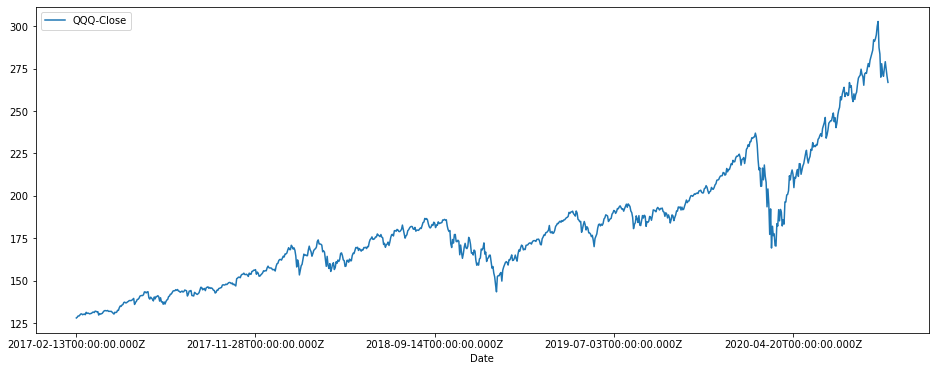

In [21]:
plt.figure()
data['Close'].plot(figsize=(16,6), label=ticker+'-Close')
if ADDXMA==1:
    data['Close-XMA'+str(xmasmall)].plot(label=ticker+'-EMA'+str(xmasmall))
    data['Close-XMA'+str(xmalong)].plot(label=ticker+'-EMA'+str(xmalong))
plt.legend()
if ADDUS10Y==1:
    data['US10Y'].plot(secondary_y=True, label='US10Y')
plt.legend()
plt.show()

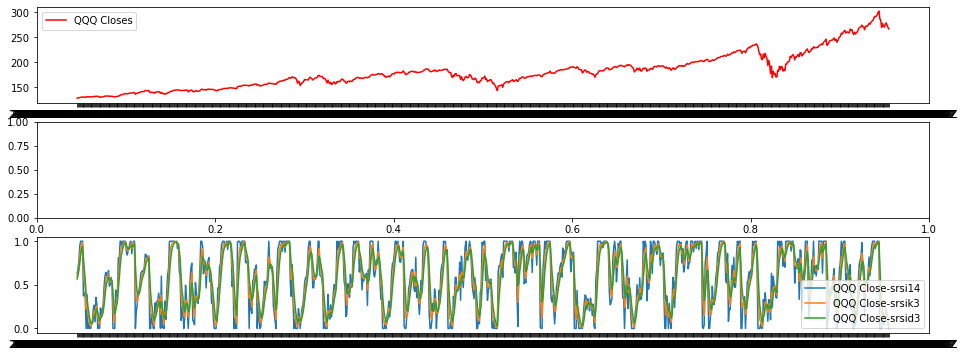

In [22]:
fig, axs = plt.subplots(3,1,figsize=(16,6))
axs[0].plot(data['Close'], color='r', label=ticker+' Closes')
if ADDXMA==1:
    axs[0].plot(data['Close-XMA'+str(xmasmall)], label=ticker+' Close-ema'+str(xmasmall))
    axs[0].plot(data['Close-XMA'+str(xmalong)], label=ticker+' Close-ema'+str(xmalong))
axs[0].legend()
if ADDRSI==1:
    axs[1].plot(data['Close-RSI'+str(RSIwindow)], label=ticker+' Close-rsi'+str(RSIwindow))
    axs[1].legend()
if ADDSTOCHRSI==1:
    axs[2].plot(data['Close-SRSI'+str(SRSIw)], label=ticker+' Close-srsi'+str(SRSIw))
    axs[2].plot(data['Close-SRSIk'+str(SRSIk)], label=ticker+' Close-srsik'+str(SRSIk))
    axs[2].plot(data['Close-SRSId'+str(SRSId)], label=ticker+' Close-srsid'+str(SRSId))
    axs[2].legend()
plt.show()

In [23]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print('Length of scaled_data = ', len(scaled_data))
print(scaled_data)

Length of scaled_data =  907
[[0.         0.6299206  0.59066139 0.55957386]
 [0.00246193 0.68957763 0.6467646  0.60726886]
 [0.00681324 0.78291283 0.71946536 0.66610407]
 ...
 [0.83882973 0.1403717  0.15019421 0.12840511]
 [0.81426772 0.05956483 0.10146978 0.10615965]
 [0.79451506 0.         0.04703754 0.06713049]]


In [24]:
train_length = int(len(scaled_data) * TrainPCT)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    print(train_data)
    print(test_data)

In [25]:
def create_dataset(dataset, noofcols, timestep=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:noofcols])
        data_y.append(dataset[i+timestep,0])
    #It has been shown that Numpy arrays need 4 times less memory compared to Python lists
    return np.array(data_x), np.array(data_y)

In [26]:
train_x, train_y = create_dataset(train_data, data_noofcols, timestep)
test_x, test_y = create_dataset(test_data, data_noofcols, timestep)

if DBGmode == 1:
    print(train_x)

In [27]:
if DBGmode == 1:
    print(train_y)

In [28]:
print('#Samples, #Timesteps, #Features - for input to LSTM')
print('train_x shape = ', train_x.shape)
print('test_x shape = ', test_x.shape)
print('train_y shape = ', train_y.shape)
print('test_y shape = ', test_y.shape)

#Samples, #Timesteps, #Features - for input to LSTM
train_x shape =  (840, 3, 4)
test_x shape =  (61, 3, 4)
train_y shape =  (840,)
test_y shape =  (61,)


In [29]:
##Samples, #Timesteps, #Features - for input to LSTM'
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], data_noofcols))
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], data_noofcols))

if DBGmode == 1:
    print(train_x)

In [30]:
#optimizer = 'adam' 'SGD' 'RMSprop' 'adadelta' 'adagrad' 'adamax' 'nadam' 'ftrl'
#activation = 'sigmoid' 'linear' relu' 'softmax' 'softplus' 'softsign' 'tanh' selu' 'elu' 'exponential' 
#loss = 'binary_crossentropy' 'mean_squared_error'

#LSTM input_shape = #timestep, #features
model = Sequential()
#model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(LSTM(50, return_sequences=True, input_shape=(timestep,data_noofcols)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(25))
model.add(Dense(1))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             11000     
_________________________________________________________________
dropout (Dropout)            (None, 3, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 32,501
Trainable params: 32,501
Non-trainable params: 0
____________________________________________________

In [31]:
model.fit(train_x, train_y, epochs=epochval, batch_size=batchval, verbose=1, validation_data=(test_x, test_y))

#Use plotting
#model.fit(train_x, train_y, epochs=epochval, batch_size=batchval, verbose=1, validation_data=(test_x, test_y), callbacks=[PlotLossesKeras()])

score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

840/840 [==============================] - 2s 3ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0164
Keras model loss =  0.0010896122548729181
Keras model accuracy =  0.0


In [32]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [33]:
#Perform inverse Scaler transform

# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols))
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols))
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [34]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [35]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[timestep:len(train_predictions)+timestep] = train_predictions

In [36]:
if DBGmode==1:
    print(test_predictions)

In [37]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+timestep+timestep:len(scaled_data)] = test_predictions

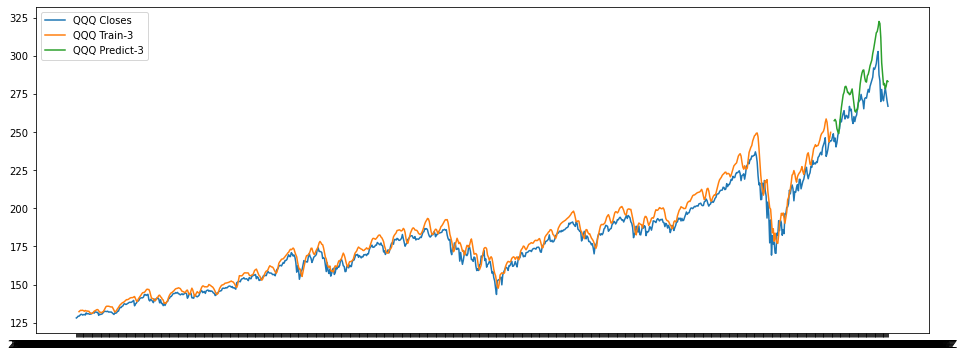

In [38]:
plt.figure(figsize=(16,6))
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train-'+str(timestep))
plt.plot(test_predict_plot, label = ticker+' Predict-'+str(timestep))
plt.legend()
plt.show()

In [39]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  907
Length of Train data =  840
Length of test data =  61


In [40]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data

,Close,Close-SRSI14,Close-SRSIk3,Close-SRSId3,AITrain,AITest
Date,,,,,,
2017-02-13T00:00:00.000Z,128.10,0.629921,0.592336,0.567280,NaN,NaN
2017-02-14T00:00:00.000Z,128.53,0.689578,0.647903,0.613350,NaN,NaN
2017-02-15T00:00:00.000Z,129.29,0.782913,0.719908,0.670181,NaN,NaN
2017-02-16T00:00:00.000Z,129.25,0.955078,0.841286,0.758493,132.238830,NaN
2017-02-17T00:00:00.000Z,129.81,1.000000,0.921903,0.841495,132.802742,NaN
...,...,...,...,...,...,...
2020-09-14T00:00:00.000Z,275.16,0.148437,0.113342,0.119239,NaN,281.807139
2020-09-15T00:00:00.000Z,279.06,0.230241,0.171792,0.145516,NaN,278.332661
2020-09-16T00:00:00.000Z,274.61,0.140372,0.156082,0.150799,NaN,280.064768


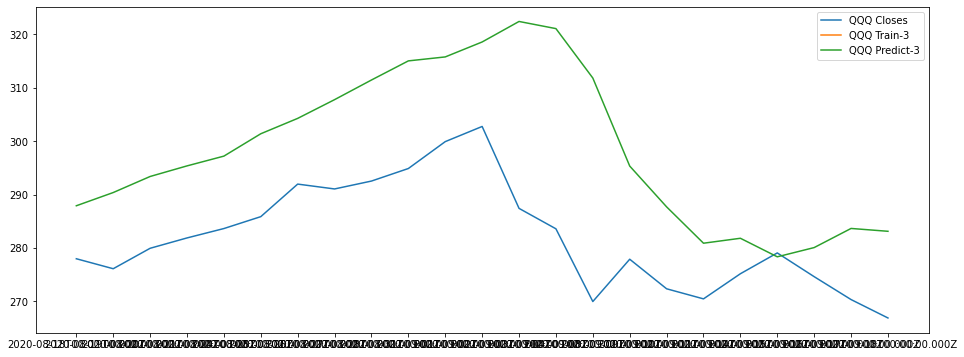

In [41]:
plt.figure(figsize=(16,6))
plt.plot(data.Close[-timestep-20:], label = ticker+' Closes')
plt.plot(train_predict_plot[-timestep-20:], label = ticker+' Train-'+str(timestep))
plt.plot(test_predict_plot[-timestep-20:], label = ticker+' Predict-'+str(timestep))
plt.legend()
plt.show()

In [42]:
data['Abs%Err']=nan
data['DirErr']=nan

In [43]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep,len(scaled_data)):
    data['Abs%Err'][i]=100*(data['AITest'][i]-data['Close'][i])/data['Close'][i]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep+1,len(scaled_data)):
    parity=0
    if ((data['Close'][i] - data['Close'][i-1])*(data['AITest'][i] - data['AITest'][i-1])) > 0:
        data['DirErr'][i]=0
        parity=1
    if parity==0:
        data['DirErr'][i]=1

if DBGmode==1:
    print('Train length = ', len(train_predictions)+timestep)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+timestep+timestep+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i-1] = ', data['Close'][ch-1])
    print('data[AITest][i]= ', data['AITest'][ch])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

In [44]:
if DBGmode==1:
    print(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
    print(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)])

In [45]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
Tot_test_len = sum(data['DirErr'].notnull())
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('timestep=', timestep)
print('')
print('----DIRECTION-----')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('')
print('----STOCK PRICE PREDICTION-----')
len(train_predictions)+timestep,len(scaled_data)-timestep
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))

timestep= 3

----DIRECTION-----
Total Test Errors =  24.0
Total Test Elements =  60
Test Direction Predict Accuracy =  60.0

----STOCK PRICE PREDICTION-----
Max % Price Error =  15.516236957564898
Min % Price Error =  -0.6131430515353529
Average % Price Error =  4.826090528104416


In [46]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')

In [47]:
if DBGmode == 0:
    pd.set_option('display.max_rows', data.shape[0]+1)
    data

print('timestep=', timestep)
data.tail(timestep+10)

timestep= 3


,Close,Close-SRSI14,Close-SRSIk3,Close-SRSId3,AITrain,AITest,Abs%Err,DirErr
Date,,,,,,,,
2020-09-01T00:00:00.000Z,299.92,1.000000,0.989280,0.977192,NaN,315.793339,5.292524,0.0
2020-09-02T00:00:00.000Z,302.76,1.000000,0.994640,0.985916,NaN,318.594880,5.230176,0.0
2020-09-03T00:00:00.000Z,287.41,0.000000,0.497320,0.741618,NaN,322.438370,12.187596,1.0
2020-09-04T00:00:00.000Z,283.58,0.000000,0.248660,0.495139,NaN,321.099366,13.230611,0.0
2020-09-08T00:00:00.000Z,269.95,0.000000,0.124330,0.309735,NaN,311.836082,15.516237,0.0
2020-09-09T00:00:00.000Z,277.88,0.177903,0.151117,0.230426,NaN,295.341704,6.283901,1.0
2020-09-10T00:00:00.000Z,272.34,0.076131,0.113624,0.172025,NaN,287.693596,5.637657,0.0
2020-09-11T00:00:00.000Z,270.45,0.042872,0.078248,0.125136,NaN,280.880694,3.856792,0.0
2020-09-14T00:00:00.000Z,275.16,0.148437,0.113342,0.119239,NaN,281.807139,2.415736,0.0


In [48]:
#*******************************************************************
#*****************Predict for next day from here********************
#*******************************************************************
#Remember to use _ob nomenclature for clean predict

st_date_ob = '2018-1-1' #doesnt really matter, we will take on -timestep elements
en_date_ob = datetime.date(datetime.now())
#yday = today - timedelta(days=1)
response_ob = get_stock_data(ticker, st_date_ob, en_date_ob)
dates_ob, closes_ob, opens_ob, highs_ob, lows_ob, vols_ob = parse_data(response_ob)

#**** Define New Column Label here
datastock_ob = pd.DataFrame(columns = ['Close'], index = dates_ob)
dfindex_ob = datastock_ob.index
dfindex_ob.name = 'Date'

#**** ADD New Column Data here
datastock_ob['Close']=closes_ob

if ADDUS10Y==1:
    us10y_data_ob = quandl.get("FRED/DGS10", start_date=st_date_ob, end_date=en_date_ob, api_key = 'tNjFxT5wYAG7nbemafxi')
    us10y_data_ob=us10y_data_ob.reset_index()
    us10y_data_ob.rename(columns = {'Value':'US10Y'}, inplace = True) 
    
    for row in range(0,len(us10y_data_ob)):
        us10y_data_ob['Date'][row]=str(us10y_data_ob['Date'][row])[:10]+'T00:00:00.000Z'
    us10y_data_ob=us10y_data_ob.set_index('Date')
    
    #****APPEND US10Y data here to a separate column in a new dataframe
    data_ob=pd.concat([datastock_ob, us10y_data_ob], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data_ob['US10Y'].fillna(method='ffill', inplace=True)
else:
    data_ob=datastock_ob
    
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #xmasmall=5
    #xmalong=9
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=smasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=smalong).mean()

    #Enter EMA Data - defined at the top
    #xmasmall=7
    #xmalong=14
    data_ob['Close-XMA'+str(xmasmall)] = data_ob.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data_ob['Close-XMA'+str(xmalong)] = data_ob.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow_ob=xmalong
    data_ob.drop(data_ob.index[0:droprow_ob], inplace = True)

#Add RSI here
if ADDRSI == 1:
    data_ob['Close-RSI'+str(RSIwindow)] = computeRSI(data_ob['Close'], RSIwindow)
    #data.drop(data.index[0:RSIwindow], inplace = True)
    
#Add STOCHRSI here
if ADDSTOCHRSI == 1:
    data_ob['Close-SRSI'+str(SRSIw)], data_ob['Close-SRSIk'+str(SRSIk)], data_ob['Close-SRSId'+str(SRSId)] = StochRSI_EMA(data_ob['Close'], SRSIw, SRSIk, SRSId)
    #data.drop(data.index[0:SRSIw*2], inplace = True)

#Drop rows on which RSI or SRSI are first computed
if ADDRSI == 1 and ADDSTOCHRSI == 1:
    data_ob.drop(data_ob.index[0:max(RSIwindow,SRSIw*2)], inplace = True)
if ADDRSI == 0 and ADDSTOCHRSI == 1:
    data_ob.drop(data_ob.index[0:SRSIw*2], inplace = True)
if ADDRSI == 1 and ADDSTOCHRSI == 0:
    data_ob.drop(data_ob.index[0:RSIwindow], inplace = True)
    
data_noofcols_ob = len(data_ob.columns)

datafilt_ob = data_ob[-timestep:]
print('datafilt_ob')
print(datafilt_ob)

scaled_datafilt_ob = scaler.transform(datafilt_ob)
print('scaled_datafilt_ob')
print(scaled_datafilt_ob)

data_x_ob = []
data_x_ob.append(scaled_datafilt_ob)
data_x_ob = np.array(data_x_ob)
print(data_x_ob.shape)
print('data_x_ob')
print(data_x_ob)
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[2], 1))

train_predictions_ob = model.predict(data_x_ob)
print('train_predictions_ob')
print(train_predictions_ob)

# create empty table with data_noofcols fields
train_predictions_like_ob = np.zeros(shape=(len(train_predictions_ob), data_noofcols_ob))
# put the predicted values in the right field
train_predictions_like_ob[:,0] = train_predictions_ob[:,0]
# inverse transform and then select the right field
train_predictions_ob = scaler.inverse_transform(train_predictions_like_ob)[:,0]

print('inverse scaled train_predictions_ob')
print(train_predictions_ob)

datafilt_ob
                           Close  Close-SRSI14  Close-SRSIk3  Close-SRSId3
Date                                                                      
2020-09-16T00:00:00.000Z  274.61      0.140372      0.156082      0.150799
2020-09-17T00:00:00.000Z  270.32      0.059565      0.107823      0.129311
2020-09-18T00:00:00.000Z  266.87      0.000000      0.053912      0.091611
scaled_datafilt_ob
[[0.83882973 0.1403717  0.15019421 0.12840511]
 [0.81426772 0.05956483 0.10146978 0.10615965]
 [0.79451506 0.         0.04703754 0.06713049]]
(1, 3, 4)
data_x_ob
[[[0.83882973 0.1403717  0.15019421 0.12840511]
  [0.81426772 0.05956483 0.10146978 0.10615965]
  [0.79451506 0.         0.04703754 0.06713049]]]
train_predictions_ob
[[0.85621524]]
inverse scaled train_predictions_ob
[277.64655357]


In [49]:
print(ticker, ' predict = ', float(train_predictions_ob), ' on ', en_date_ob)

QQQ  predict =  277.64655356884003  on  2020-09-21
